<a href="https://colab.research.google.com/github/jpmedras/programming-problem-classifier/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset
from torch import tensor

class ProblemDataset(Dataset):
    def __init__(self, data, inputs_encoder, labels_encoder):
        self.inputs = inputs_encoder(data['inputs'])
        self.labels = labels_encoder(data['labels'])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

def tolist(dataset):
    inputs = []
    labels = []

    for inp, lab in dataset:
        inputs.append(inp[0, :].numpy().tolist())
        labels.append(lab.numpy().tolist())

    labels = [item for sublist in labels for item in sublist]

    return inputs, labels

In [2]:
from torch.utils.data import DataLoader

def create_dataloader(dataset, batch_size, type):
    if type == 'train':
        shuffle = True
    else:
        shuffle = False

    loader = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, shuffle=shuffle)

    return loader

In [3]:
from torch import tensor, long
from torch import unsqueeze, cat
from transformers import BertTokenizer

def define_encoders(max_len):
    def inputs_encoder(inputs):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased').encode_plus
        encoded_inputs = []
        for input in inputs:
            encoding = tokenizer(
                text=input,
                add_special_tokens=True,
                padding='max_length',
                truncation='longest_first',
                max_length=max_len
            )

            input_ids = encoding['input_ids']
            attention_mask = encoding['attention_mask']
            token_type_ids = encoding['token_type_ids']

            encoded_input_ids = tensor(input_ids, dtype=long).unsqueeze(0)
            encoded_attention_mask = tensor(attention_mask, dtype=long).unsqueeze(0)
            encoded_token_type_ids = tensor(token_type_ids, dtype=long).unsqueeze(0)

            encoded_input = cat((encoded_input_ids, encoded_attention_mask, encoded_token_type_ids), dim = 0).unsqueeze(0)
            encoded_inputs.append(encoded_input)

        try:
            encoded = cat(encoded_inputs)
            return encoded
        except:
            print('Number of inputs:', len(encoded_inputs))
            max_dif = max([e.shape[2] for e in encoded_inputs])
            print('Max shape:', max_dif)
            for idx, e in enumerate(encoded_inputs):
                if e.shape[2] != max_len:
                    print(idx)
                    print(e.shape[2])
                    print(inputs[idx])
                    break
            return None

    def labels_encoder(labels):
        encoded_labels = []
        for label in labels:
            encoded_labels.append(
                tensor([label], dtype=long).unsqueeze(0)
            )

        encoded = cat(encoded_labels)

        return encoded

    return inputs_encoder, labels_encoder

In [4]:
import pandas as pd

def load_data(data_path):
    df = pd.read_csv(data_path, encoding='utf-8')
    data = {
        'inputs': df.inputs.values.tolist(),
        'labels': df.labels.values.tolist()
    }

    return data

In [5]:
import torch
import random
import numpy as np

def define_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    #torch.use_deterministic_algorithms(True)

In [6]:
from torch.utils.data import random_split
from torch import Generator

def split_data(dataset, lengths, seed=42):
    assert len(lengths) == 2, "You must define the size of train dataset and test dataset"

    train_set, test_set = random_split(dataset, lengths, Generator().manual_seed(seed))

    return train_set, test_set

In [7]:
import torch
from torch import long

def calc_loss(model, dataloader, criterion):
    with torch.no_grad():
        total_loss = 0.
        for inputs, labels in dataloader:
            ids = inputs[:, 0].to(model.device, dtype=long)
            masks = inputs[:, 1].to(model.device, dtype=long)
            tti = inputs[:, 2].to(model.device, dtype=long)
            labels = labels.squeeze().to(model.device, dtype=long)

            outputs = model(ids, masks, tti)

            loss = criterion(outputs, labels)

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)

        return average_loss

In [38]:
import torch
from torch import nn, long, argmax, optim, save
from transformers import BertModel
from torch import cuda

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

class BERTModule(nn.Module):
    def __init__(self, n_classes, dropout_p = 0.3):
        super(BERTModule, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # for param in self.bert.parameters():
        #   param.requires_grad = False
        self.dropout = nn.Dropout(p = dropout_p)
        self.fc = nn.Linear(768, n_classes)

        self.device = 'cuda' if cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, ids, masks, ttis):
        _, pooled_output = self.bert(ids, attention_mask = masks, token_type_ids = ttis, return_dict = False)
        output_drop = self.dropout(pooled_output)
        output = self.fc(output_drop)

        return output

    def fit(self, train_loader, test_loader, epochs = 10, learning_rate = 1e-05):
        self.epochs = epochs
        self.learning_rate = learning_rate

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(params = self.parameters(), lr = self.learning_rate)

        self.to(self.device)

        self.train()

        train_losses = []
        test_losses = []

        print('Begin training...')

        for epoch in range(self.epochs):
            train_loss = 0.

            for inputs, labels in train_loader:
                optimizer.zero_grad()

                ids = inputs[:, 0].to(self.device, dtype=long)
                masks = inputs[:, 1].to(self.device, dtype=long)
                tti = inputs[:, 2].to(self.device, dtype=long)
                labels = labels.squeeze().to(self.device, dtype=long)

                assert ids.shape == masks.shape, 'Ids != Masks'
                assert masks.shape == tti.shape, 'Masks != Ttis'
                assert ids.shape == tti.shape, 'Ids != Ttis'

                assert ids.shape[0] == labels.shape[0], 'inputs and labels are incompatible'

                outputs = self(ids, masks, tti)

                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            avg_test_loss = calc_loss(self, test_loader, criterion)

            train_losses.append(avg_train_loss)
            test_losses.append(avg_test_loss)

            print(f'Epoch {epoch + 1}/{self.epochs} Train Loss: {avg_train_loss} Test Loss: {avg_test_loss}')

        print('Ending training...')

        model_name = 'model' + '_' + 'ep' + str(self.epochs) + '_' + 'lr' + str(self.learning_rate) + '.pth'
        save(self.state_dict(), model_name)

        return train_losses, test_losses

    def evaluate(self, dataloader):
        self.eval()

        data_labels = []
        data_outputs = []

        with torch.no_grad():
            for inputs, labels in dataloader:

                ids = inputs[:, 0].to(self.device, dtype=long)
                masks = inputs[:, 1].to(self.device, dtype=long)
                tti = inputs[:, 2].to(self.device, dtype=long)
                labels = labels.squeeze().to(self.device, dtype=long)

                assert ids.shape == masks.shape, 'Ids != Masks'
                assert masks.shape == tti.shape, 'Masks != Ttis'
                assert ids.shape == tti.shape, 'Ids != Ttis'

                assert ids.shape[0] == labels.shape[0], 'inputs and labels are incompatible'

                outputs = self(ids, masks, tti)
                outputs = nn.functional.softmax(outputs, dim=1)
                outputs = argmax(outputs, dim=1)

                data_labels.extend(labels.cpu().detach().numpy().tolist())
                data_outputs.extend(outputs.cpu().detach().numpy().tolist())

        target_names = ['Easy', 'Medium', 'Hard']
        macro_f1 = f1_score(data_labels, data_outputs, average='macro')
        cm = confusion_matrix(data_labels, data_outputs)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        print(f'Macro F1: {macro_f1}')
        disp.plot()
        plt.show()

    def predict(self, text):
        self.eval()

        target_names = ['Easy', 'Medium', 'Hard']

        input_encoder, _ = define_encoders(max_len=300)

        with torch.no_grad():
            input = input_encoder([text])

            ids = input[:, 0].to(self.device, dtype=long)
            masks = input[:, 1].to(self.device, dtype=long)
            tti = input[:, 2].to(self.device, dtype=long)

            assert ids.shape == masks.shape, 'Ids != Masks'
            assert masks.shape == tti.shape, 'Masks != Ttis'
            assert ids.shape == tti.shape, 'Ids != Ttis'

            output = self(ids, masks, tti)
            output = nn.functional.softmax(output, dim=1)
            output = argmax(output, dim=1)

            output = output.cpu().detach().numpy().tolist()

            print(f'Text: {text}')
            print(f'Difficulty: {target_names[output[0]]}')

In [13]:
import matplotlib.pyplot as plt

def show_loss_evolution(num_epochs, train_losses, test_losses):
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Train')
    plt.plot(range(1, num_epochs + 1), test_losses, marker='x', linestyle='-', color='g', label='Test')

    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

In [50]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

SEED = 42
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
DATA_PATH = 'leetcode.csv'

define_seed(SEED)

inputs_encoder, labels_encoder = define_encoders(MAX_LEN)

data = load_data(data_path=DATA_PATH)

dataset = ProblemDataset(
    data=data,
    inputs_encoder=inputs_encoder,
    labels_encoder=labels_encoder
)
train_set, test_set = split_data(
    dataset=dataset,
    lengths=[0.85, 0.15],
    seed=SEED
)

train_loader = create_dataloader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, type='train')
test_loader = create_dataloader(dataset = test_set, batch_size = TEST_BATCH_SIZE, type='test')

model = BERTModule(n_classes = 3)

train_losses, test_losses = model.fit(train_loader=train_loader, test_loader=test_loader, epochs = EPOCHS, learning_rate = LEARNING_RATE)

Begin training...
Epoch 1/10 Train Loss: 1.0128549596955698 Test Loss: 1.0622000666765066
Epoch 2/10 Train Loss: 0.9511229466366512 Test Loss: 1.0373266687759986
Epoch 3/10 Train Loss: 0.876926592921698 Test Loss: 0.9863898932933808
Epoch 4/10 Train Loss: 0.7809429942600189 Test Loss: 1.011210811138153
Epoch 5/10 Train Loss: 0.6390009768387322 Test Loss: 1.1216600670264318
Epoch 6/10 Train Loss: 0.4581365206389017 Test Loss: 1.1397187141271738
Epoch 7/10 Train Loss: 0.298803532916692 Test Loss: 1.4686322721151206
Epoch 8/10 Train Loss: 0.19799815368668366 Test Loss: 1.4611942020746378
Epoch 9/10 Train Loss: 0.14017008954999588 Test Loss: 1.7255288499479111
Epoch 10/10 Train Loss: 0.10820852059830902 Test Loss: 1.6538084637660246
Ending training...


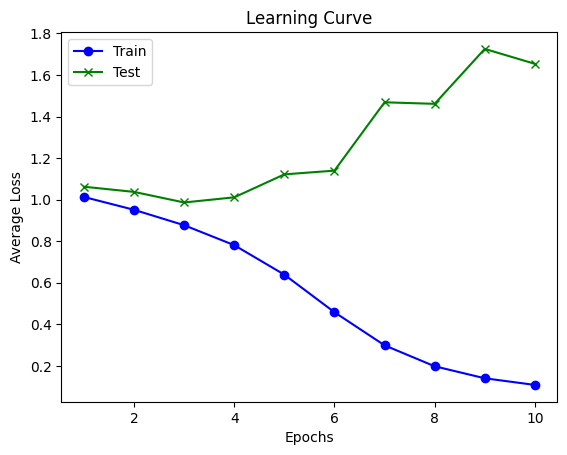

In [53]:
show_loss_evolution(EPOCHS, train_losses, test_losses)

Macro F1: 0.9865229148492333


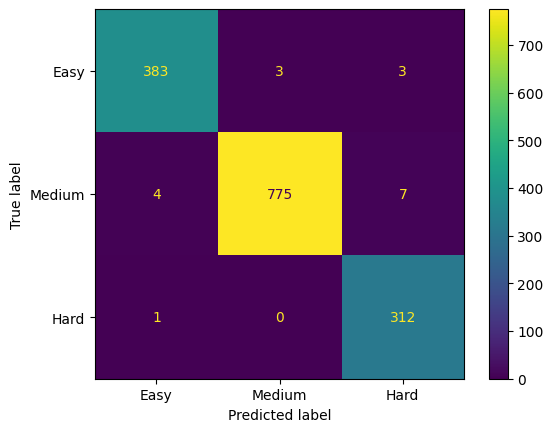

In [51]:
model.evaluate(dataloader=train_loader)

Macro F1: 0.4920403474129498


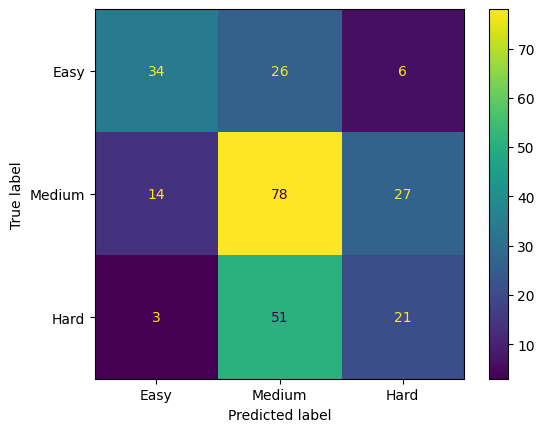

In [52]:
model.evaluate(dataloader=test_loader)

In [46]:
from torch import load

model_path = 'model_ep5_lr1e-05.pth'

model = BERTModule(n_classes = 3)
model.load_state_dict(load(model_path))

text = """Given an integer x, return true if x is a palindrome, and false otherwise."""

model.predict(text=text)

Text: Given an integer x, return true if x is a palindrome, and false otherwise.
Difficulty: Easy
